In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.utils import to_categorical

In [14]:
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train[:1%]', 'test'], as_supervised=True, with_info=True)

X_train shape: (600, 28, 28, 1)
600 train samples
10000 test samples


In [18]:
train_data = tfds.as_numpy(ds_train)
test_data = tfds.as_numpy(ds_test)

X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

X_train = tf.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = tf.reshape(X_test, (X_test.shape[0], 28, 28, 1))

X_train /= 255.0
X_test /= 255.0

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = to_categorical(y_train, num_classes=ds_info.features['label'].num_classes)
y_test = to_categorical(y_test, num_classes=ds_info.features['label'].num_classes)

X_train shape: (600, 28, 28, 1)
600 train samples
10000 test samples


In [20]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (10000, 28, 28, 1)
10000 train samples
600 test samples


In [19]:
temp=X_train
X_train=X_test
X_test=temp

In [5]:
nb_classes=10

In [22]:
x = Input(shape=(28, 28,1))
# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)

# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [23]:
epochs = 5
batch_size = 128
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
79/79 [==============================] - 15s 165ms/step - loss: 0.6914 - val_loss: 0.6912
Epoch 2/5
79/79 [==============================] - 18s 225ms/step - loss: 0.6910 - val_loss: 0.6908
Epoch 3/5
79/79 [==============================] - 11s 138ms/step - loss: 0.6905 - val_loss: 0.6903
Epoch 4/5
79/79 [==============================] - 12s 146ms/step - loss: 0.6900 - val_loss: 0.6898
Epoch 5/5
79/79 [==============================] - 12s 149ms/step - loss: 0.6894 - val_loss: 0.6892


19/19 [==============================] - 0s 12ms/step


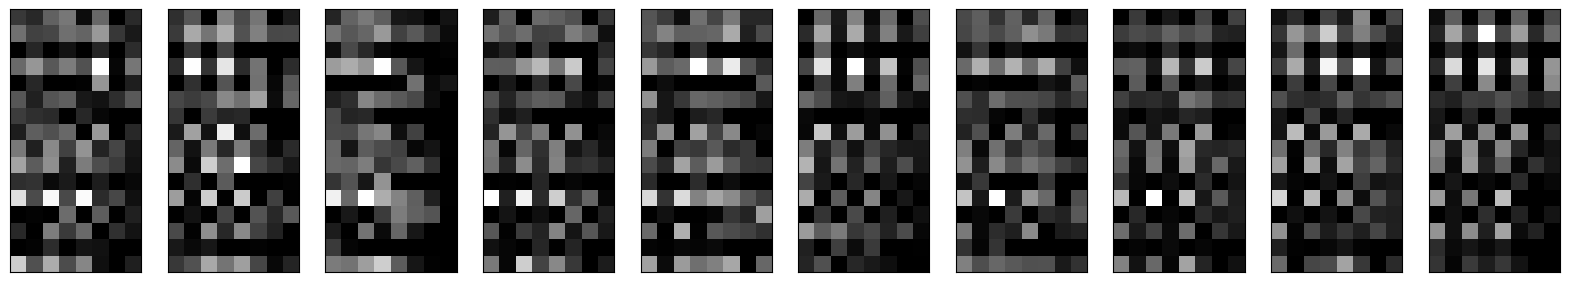

In [26]:
conv_encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[6].output)
encoded_imgs = conv_encoder.predict(X_test)
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(8, 16).T, cmap='gray')  # Adjust the cmap if needed
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
decoded_imgs = autoencoder.predict(X_test)

19/19 [==============================] - 0s 13ms/step


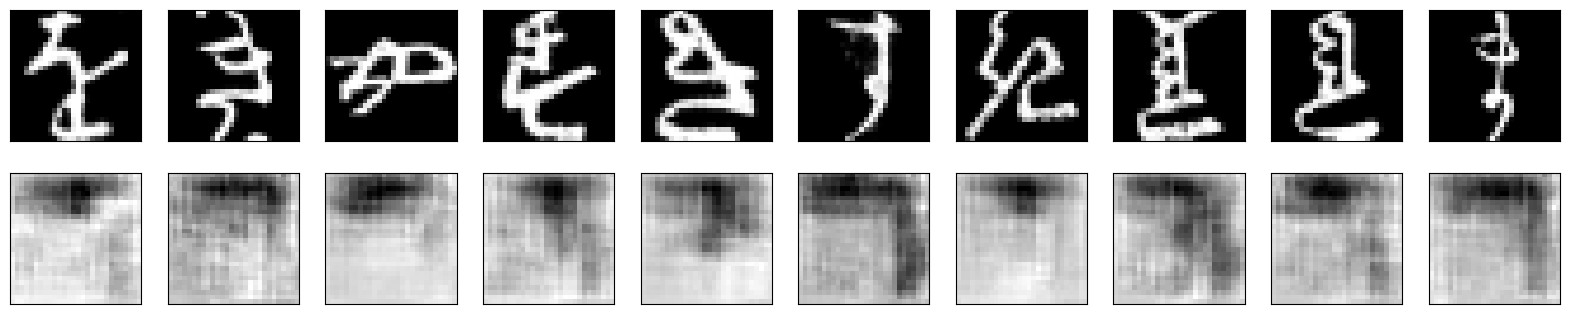

In [30]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(tf.reshape(X_test[i], (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(tf.reshape(decoded_imgs[i], (28, 28)), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

dict_keys(['loss', 'val_loss'])


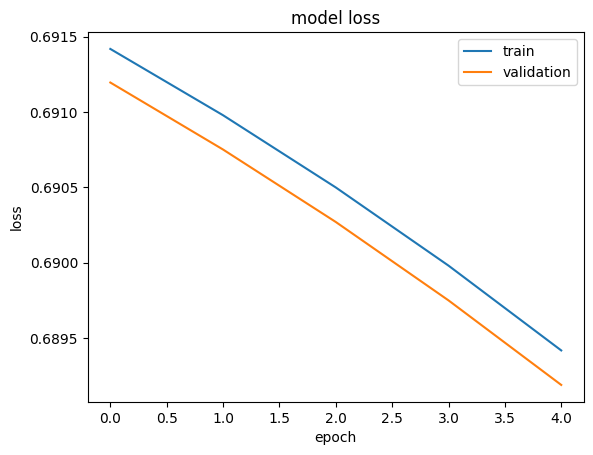

In [31]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [32]:
import pickle
# Save the trained model
autoencoder.save('autoencoder_model')
# Save the training history
with open('training_history.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)